<a href="https://colab.research.google.com/github/smolinad/quantum_machine_learning/blob/main/Reproduced_QCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Machine learning Project:** QCNN implementation in MNIST
**Sergio Quiroga Sandoval \
squirogas@unal.edu.co \
Universidad Nacional de Colombia**\
This project is a modified reproduction of the **pennylane** tutorials for QCNN models at Andrea Mari: [Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution/). March 23, 2020.

*Implementation of the paper "Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits." by Henderson, et al.*

We also retrieved information from **Medium** Arnaud Robin and Stanislav I Slavov:    [Implementing Quantum Convolutional Neural Networks](https://medium.com/mit-6-s089-intro-to-quantum-computing/quanvolutional-neural-networks-might-be-the-future-of-deep-learning-heres-why-5377bfc03652) Jan 27, 2022.

## Changes made in this implementation from the Pennylane docs:
*We set a different dataset size and eliminate some Differences between the tutorial and the proposed model in the original paper.
Aiming to reproduce the model as it was proposed.


*   We will test the model on 1000 samples from MNIST dataset (They used 70000 samples and ran the model on QxBranch quantum computer simulation system).

Future changes:
*   Generation of the random quantum circuit. (pag 5 Quanvolutional filter generation methodology)
*   Use of a $3 \times 3$ quanvolution filter size, instead of $2 \times 2$ done in the tutorial.



**Extracted passages from the paper**

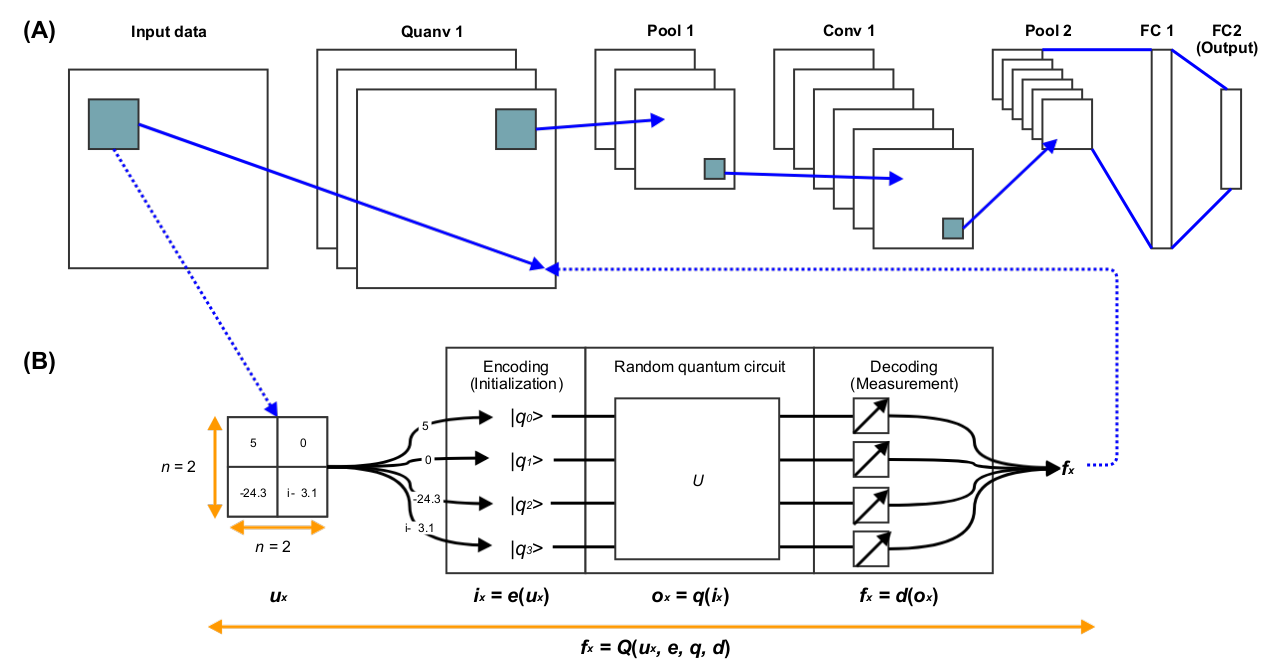

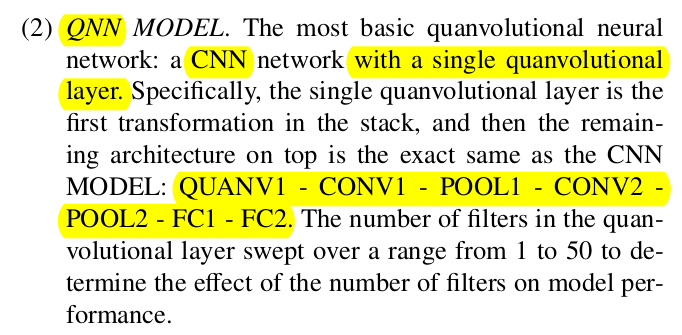

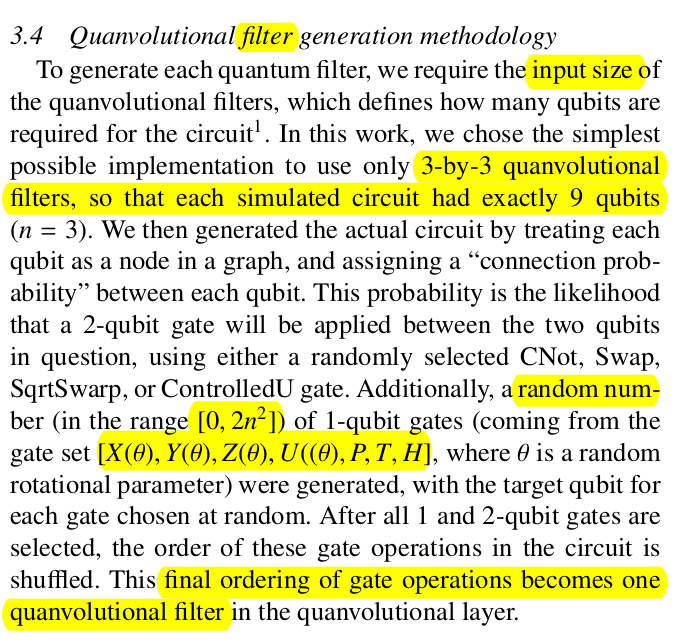

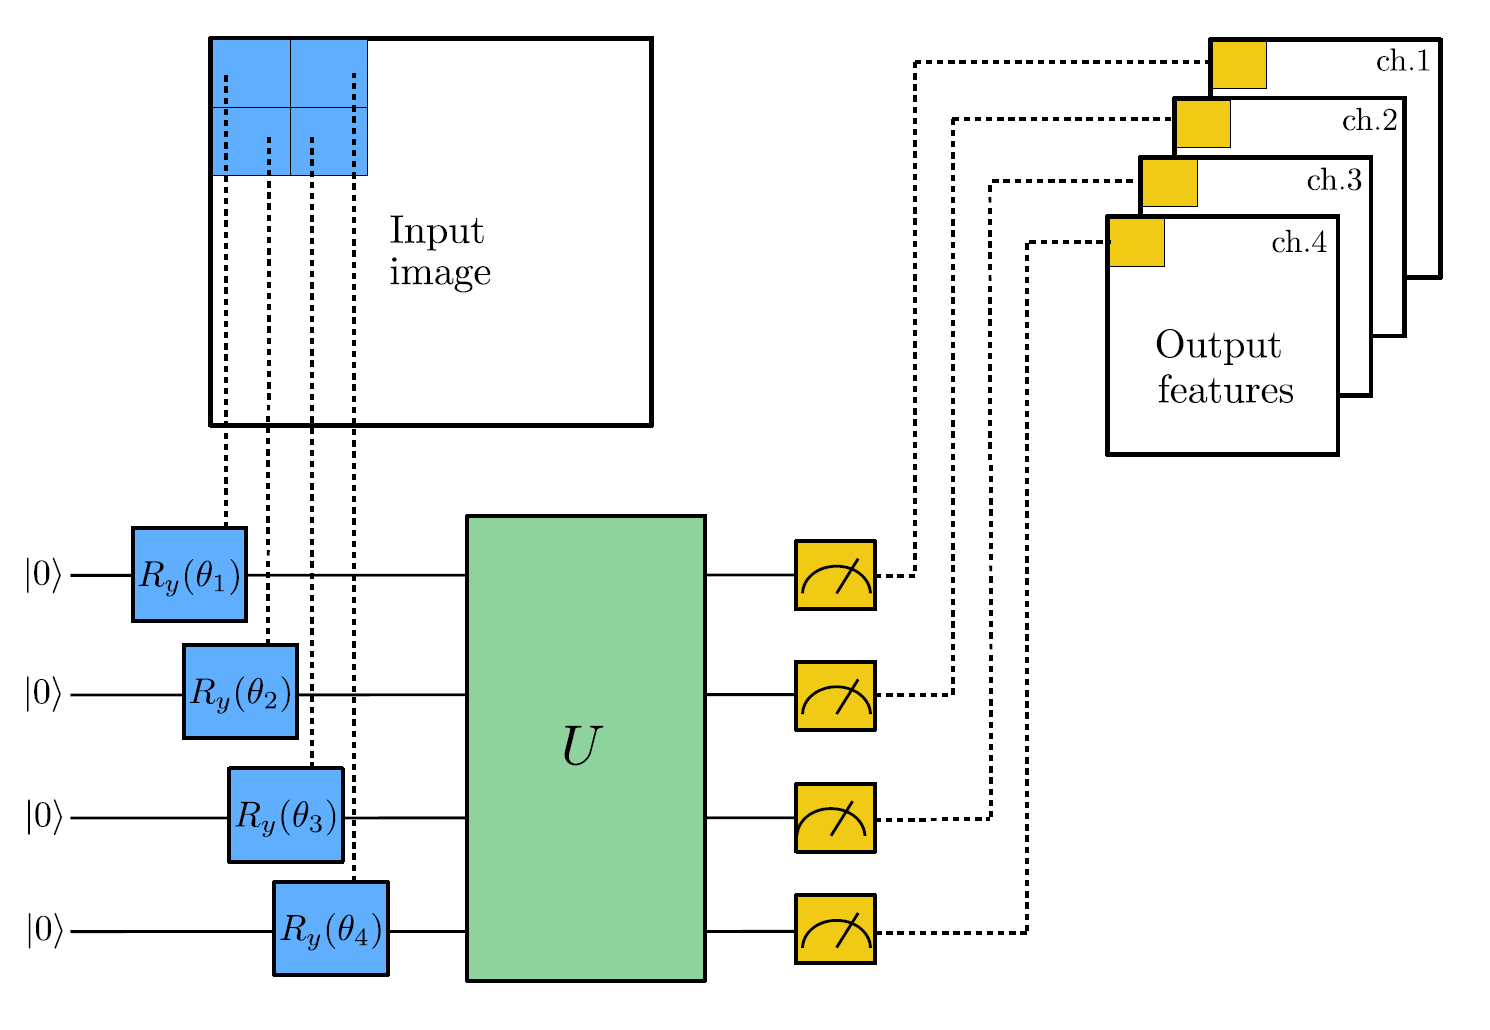

## The model

*   A small region of the input image, in our example a 2×2 square, is embedded
into a quantum circuit. In this demo, this is achieved with **parametrized rotations** applied to the qubits initialized in the ground state.

*   A quantum computation, associated to a **unitary U**, is performed on the system. The unitary could be generated by a variational quantum circuit or, more simply, by a **random circuit** as proposed in Ref. [1].

*   The quantum system is finally **measured**, obtaining a list of classical **expectation values**. The measurement results could also be classically post-processed as proposed in Ref. [1] but, for simplicity, in this demo we directly use the raw expectation values.

*  Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.

*   Iterating the same procedure over different regions, one can scan the full input image, producing an output object which will be structured as a multi-channel image.

The quantum convolution can be followed by further quantum layers or by classical layers.

## Setup

PennyLane with the TensorFlow interface and the plotting library matplotlib.

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 66.0 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Hyperparameters

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 800    # Size of the train dataset
n_test = 200     # Size of the test dataset

SAVE_PATH = "/data_saving_folder"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## Loading of the MNIST dataset

Importing MNIST from Keras.

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 [==============================] - 0s 0us/step


# Quantum circuit as a convolution kernel

We initialize a PennyLane default.qubit device, simulating a system of 4 qubits.\
 The associated qnode represents the quantum circuit consisting of:


*   An embedding layer of local Ry rotations (with angles scaled by a factor of π);
*   Random circuit of n_layers;
*   A final measurement in the computational basis, estimating 4 expectation values.



In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

**Convolution scheme**

*   the image is divided into squares of 2×2 pixels.
*   Each square is processed by the quantum circuit.
*   The 4 expectation values are mapped into 4 different channels of a single output pixel.\
This process halves the resolution of the input image. In the standard language of CNN, this would correspond to a convolution with a 2×2 kernel and a stride equal to 2.


In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset
Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.\
The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


# The data saving folder may produce an error, you can fix it by changing the SAVE_PATH from the first block of code to a new folder

Quantum pre-processing of train images:


Visualize the effect of the quantum convolution layer on a batch of samples:

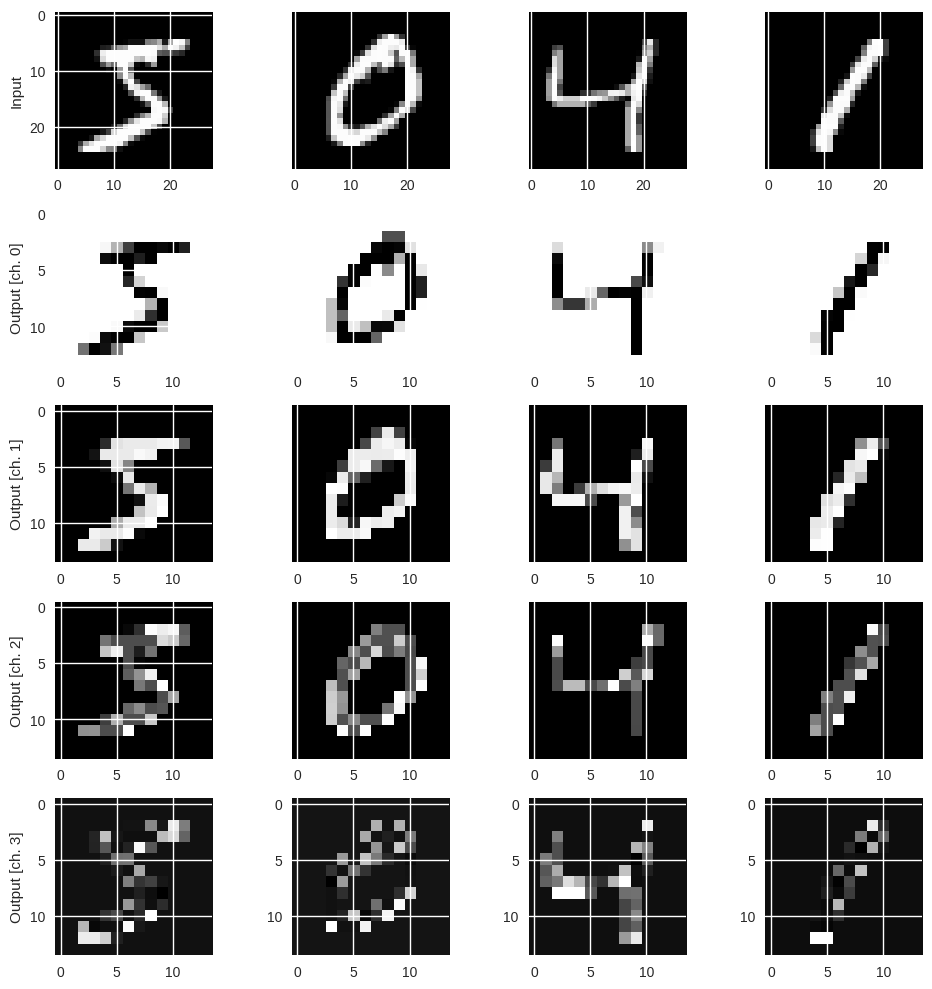

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Hybrid quantum-classical model
After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the  
10 different digits of the MNIST dataset.\
Simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.
The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**Training**
We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
200/200 - 1s - loss: 1.4672 - accuracy: 0.5625 - val_loss: 0.9436 - val_accuracy: 0.7600 - 821ms/epoch - 4ms/step
Epoch 2/30
200/200 - 0s - loss: 0.6970 - accuracy: 0.8288 - val_loss: 0.6938 - val_accuracy: 0.7950 - 352ms/epoch - 2ms/step
Epoch 3/30
200/200 - 0s - loss: 0.5180 - accuracy: 0.8625 - val_loss: 0.5548 - val_accuracy: 0.8400 - 332ms/epoch - 2ms/step
Epoch 4/30
200/200 - 0s - loss: 0.4112 - accuracy: 0.8975 - val_loss: 0.4837 - val_accuracy: 0.8550 - 328ms/epoch - 2ms/step
Epoch 5/30
200/200 - 0s - loss: 0.3494 - accuracy: 0.9125 - val_loss: 0.4408 - val_accuracy: 0.8900 - 359ms/epoch - 2ms/step
Epoch 6/30
200/200 - 0s - loss: 0.2905 - accuracy: 0.9362 - val_loss: 0.4585 - val_accuracy: 0.8550 - 336ms/epoch - 2ms/step
Epoch 7/30
200/200 - 0s - loss: 0.2559 - accuracy: 0.9362 - val_loss: 0.3997 - val_accuracy: 0.8600 - 338ms/epoch - 2ms/step
Epoch 8/30
200/200 - 0s - loss: 0.2156 - accuracy: 0.9550 - val_loss: 0.3715 - val_accuracy: 0.9000 - 433ms/epoch - 2ms/step


In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images to compare the results achievable with and without the quantum convolution layer,

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
200/200 - 1s - loss: 1.4444 - accuracy: 0.6237 - val_loss: 0.9914 - val_accuracy: 0.7850 - 854ms/epoch - 4ms/step
Epoch 2/30
200/200 - 0s - loss: 0.7061 - accuracy: 0.8587 - val_loss: 0.7017 - val_accuracy: 0.8300 - 361ms/epoch - 2ms/step
Epoch 3/30
200/200 - 0s - loss: 0.5172 - accuracy: 0.8850 - val_loss: 0.5818 - val_accuracy: 0.8600 - 423ms/epoch - 2ms/step
Epoch 4/30
200/200 - 0s - loss: 0.4183 - accuracy: 0.9013 - val_loss: 0.5204 - val_accuracy: 0.8450 - 351ms/epoch - 2ms/step
Epoch 5/30
200/200 - 0s - loss: 0.3578 - accuracy: 0.9175 - val_loss: 0.4542 - val_accuracy: 0.8650 - 322ms/epoch - 2ms/step
Epoch 6/30
200/200 - 0s - loss: 0.3110 - accuracy: 0.9300 - val_loss: 0.4212 - val_accuracy: 0.8800 - 341ms/epoch - 2ms/step
Epoch 7/30
200/200 - 0s - loss: 0.2753 - accuracy: 0.9400 - val_loss: 0.3895 - val_accuracy: 0.8950 - 337ms/epoch - 2ms/step
Epoch 8/30
200/200 - 0s - loss: 0.2432 - accuracy: 0.9438 - val_loss: 0.3749 - val_accuracy: 0.8900 - 327ms/epoch - 2ms/step


## Results


<ipython-input-48-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


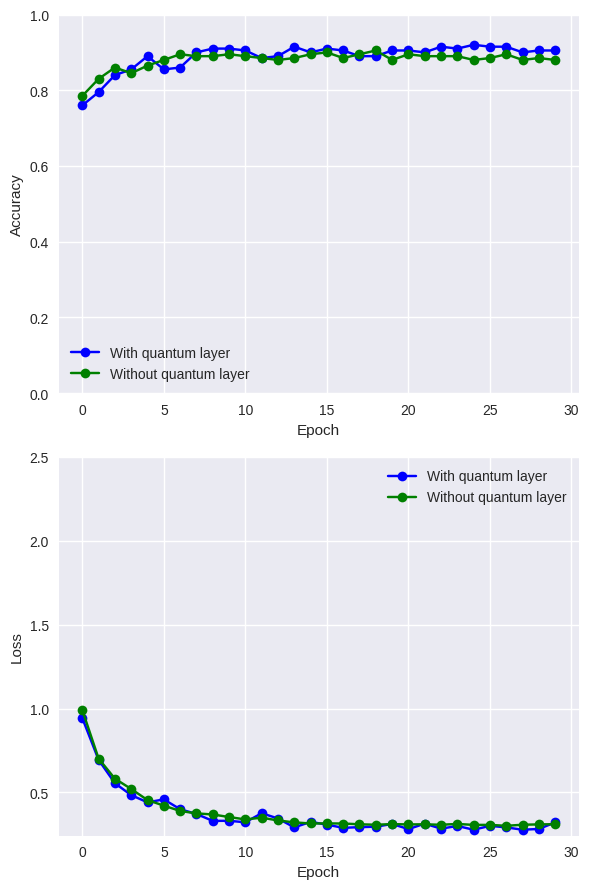

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Note: after 30 epochs and one convolutional layer we get 90.5% accuracy on 1000 MNIST samples. (using a $2\times 2$ kernel)

3x3 kernel


# References



*  Andrea Mari: Quanvolutional Neural Networks. March 23, 2020. Last updated January 14, 2021.
*  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.





# Note:
Henderson et al. Reported paper results:

With 70.000 samples of MNIST, 25 or 50 convolutional filters with size $3 \times3$ they achieve more than 95% accuracy.


